# Week 3: Analyse customer sentiments with reviews

## Scenario:

Leaders at Turtle Games understand that in order to maximise sales performance, they must offer products with which their customers are satisfied. Turtle Games' e-commerce site features the ability for customers to leave reviews. If customers are dissatisfied with faulty or underperforming products, sales will be impacted.

## Objective:

Using the reviews collected from Turtle Games' e-store, identify the customer sentiments based on their reviews for toys and games.

- What is the general sentiment of customers across all products?
- Based on the polarity of the sentiment, what are the top 20 positive and top 20 negative reviews?

## Pre-processing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

Rationale for libaries:
- Numpy: used for statistical calculations
- Pandas: used for data manipulation and analysis
- NLTK: used for symbolic and natural language prcoessing for English
- Matplotlib: needed for producing visualisations

In [2]:
# Import data as Data Frame
df_gamereviews = pd.read_csv("game_reviews.csv")

In [3]:
# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

Rationale: Warnings usually occur when there are obsolete programming elements. Warnings have been turned off to make the code cleaner. However, this will still allow errors to appear.

In [4]:
# Explore data - understand how many rows and columns are in the data
df_gamereviews.shape

(15000, 9)

**Observations:** There are 15000 rows and 9 columns

In [5]:
# Explore data - get a rough idea of the contents
df_gamereviews.head()

,overall,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,image
0,2,False,"09 22, 2016",A1IDMI31WEANAF,Mackenzie Kent,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...,1474502400,NaN
1,1,False,"09 18, 2016",A4BCEVVZ4Y3V3,Jonathan Christian,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...,1474156800,NaN
2,3,True,"09 12, 2016",A2EZ9PY1IHHBX0,unpreparedtodie,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless",1473638400,NaN
3,5,True,"03 02, 2017",A139PXTTC2LGHZ,Ashley,Amazing buy! Bought it as a gift for our new d...,Five Stars,1488412800,NaN
4,1,True,"02 08, 2017",A3IB33V29XIL8O,Oghma_EM,As my review of GF9's previous screens these w...,Money trap,1486512000,NaN


**Observations:** The 'reviewText' column is the most useful to answer the business questions in this analysis.

In [6]:
# Explore data - examine types of data stored in each column
df_gamereviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         15000 non-null  int64 
 1   verified        15000 non-null  bool  
 2   reviewTime      15000 non-null  object
 3   reviewerID      15000 non-null  object
 4   reviewerName    15000 non-null  object
 5   reviewText      14990 non-null  object
 6   summary         14998 non-null  object
 7   unixReviewTime  15000 non-null  int64 
 8   image           160 non-null    object
dtypes: bool(1), int64(2), object(6)
memory usage: 952.3+ KB


**Observations:** There are 15000 observations and 8 columns. Most variables are objects, except for "overall" (integer), "verified" (boolean), and "unixReviewTime" (integer). There are several missing values for "image" and a few missing values for "reviewText" and "summary."

In [7]:
# Remove missing values
df_gamereviews.dropna(subset=['reviewText'], inplace=True)
df_gamereviews.shape

(14990, 9)

In [8]:
# Extract column containing all the reviews for analysing the text
df_reviews = pd.DataFrame(df_gamereviews['reviewText'])
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14990 entries, 0 to 14999
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  14990 non-null  object
dtypes: object(1)
memory usage: 234.2+ KB


In [9]:
# Review data for newly created 'df_reviews' DataFrame
df_reviews.head()

,reviewText
0,"When it comes to a DM's screen, the space on t..."
1,An Open Letter to GaleForce9*:\n\nYour unpaint...
2,"Nice art, nice printing. Why two panels are f..."
3,Amazing buy! Bought it as a gift for our new d...
4,As my review of GF9's previous screens these w...


In [10]:
# Convert sentences into lowercase
df_reviews['reviewText'] = df_reviews['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_reviews['reviewText'].head()

0    when it comes to a dm's screen, the space on t...
1    an open letter to galeforce9*: your unpainted ...
2    nice art, nice printing. why two panels are fi...
3    amazing buy! bought it as a gift for our new d...
4    as my review of gf9's previous screens these w...
Name: reviewText, dtype: object

In [11]:
# Remove punctuation
df_reviews['reviewText'] = df_reviews['reviewText'].str.replace('[^\w\s]','', regex=False)
df_reviews['reviewText'].head()

0    when it comes to a dm's screen, the space on t...
1    an open letter to galeforce9*: your unpainted ...
2    nice art, nice printing. why two panels are fi...
3    amazing buy! bought it as a gift for our new d...
4    as my review of gf9's previous screens these w...
Name: reviewText, dtype: object

**Rationale for converting to lowercase and removing punctuation:** This will help when we need to convert text into tokens for later analysis.

In [12]:
# Check the number of duplicate values in the reviewText column
df_reviews.reviewText.duplicated().sum()

697

In [13]:
# Drop duplicates
df_reviewsclean = df_reviews.drop_duplicates(subset=['reviewText'])

In [14]:
# Reset index and preview cleaned data
df_reviewsclean.reset_index(inplace=True)
df_reviewsclean.head()

,index,reviewText
0,0,"when it comes to a dm's screen, the space on t..."
1,1,an open letter to galeforce9*: your unpainted ...
2,2,"nice art, nice printing. why two panels are fi..."
3,3,amazing buy! bought it as a gift for our new d...
4,4,as my review of gf9's previous screens these w...


In [15]:
# Examine shape of cleaned data
df_reviewsclean.shape

(14293, 2)

**Observations:** There are 14293 rows and 2 columns in the cleaned data. This is in line with what we would expect.

## Convert text into tokens

In [16]:
# Import nltk packages for converting text into tokens
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhbil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# Apply tokens
df_reviewsclean['tokens'] = df_reviewsclean['reviewText'].apply(word_tokenize)
df_reviewsclean['tokens'].head()

0    [when, it, comes, to, a, dm, 's, screen, ,, th...
1    [an, open, letter, to, galeforce9, *, :, your,...
2    [nice, art, ,, nice, printing, ., why, two, pa...
3    [amazing, buy, !, bought, it, as, a, gift, for...
4    [as, my, review, of, gf9, 's, previous, screen...
Name: tokens, dtype: object

In [18]:
# Combine tokens into one list
all_tokens = []
for i in range(df_reviewsclean.shape[0]):
    all_tokens = all_tokens + df_reviewsclean['tokens'][i]

In [19]:
# Filter out tokens that are neither alphabets or numbers (to eliminate punctuation marks etc)
tokens1 = [word for word in all_tokens if word.isalnum()]

## Eliminate stopwords

In [20]:
# Download the nltk resource, import the method, and extract stopwords in the English language.
nltk.download ('stopwords')
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhbil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Create a list of tokens from the list of identified tokens after eliminating stopwords
tokens2 = [x for x in tokens1 if x.lower() not in english_stopwords]

In [22]:
# Create empty list to store values from list of identified tokens after eliminating stopwords
tokens2_string = ''
for value in tokens2:
    tokens2_string = tokens2_string + value + ' '

## Plot wordcloud

In [23]:
# Import WordCloud
from wordcloud import WordCloud


In [24]:
# Set parameters for wordcloud image
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(tokens2_string)

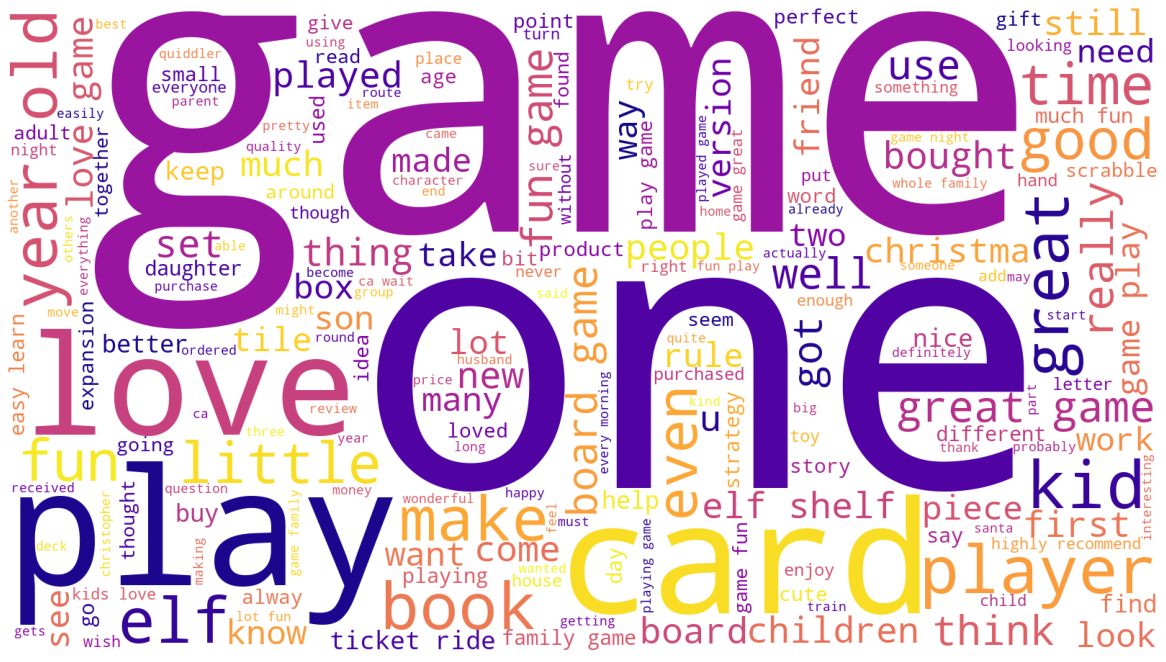

In [25]:
# Plot the WordCloud image                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Generate polarity score

In [26]:
# Import additional nltk packages needed to generate polarity score
from nltk.corpus import stopwords
from nltk.corpus import words
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

nltk.download('words')

all_english_words = set(words.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhbil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mhbil\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [27]:
# Determine values of output
results_list_values = df_reviewsclean['reviewText'].values

In [28]:
# Look at one comment
results_list_values[1]

'an open letter to galeforce9*: your unpainted miniatures are very not bad. your spell cards are great. your board games are "meh". your dm screens, however, are freaking terrible. i\'m still waiting for a single screen that isn\'t polluted with pointless artwork where useful, reference-able tables should be. once again, you\'ve created a single use screen that is only useful when running the "storm king\'s thunder" adventure. even despite the fact that it\'s geared to that adventure path, it\'s usefulness negligible, at best. i massive swath of the inner panel is wasted on artwork and a bloated overland map, which could have been easily reduced to a single panel in size. and the few table you have are nigh-useless themselves. in short, stop making crap dm screens.'

**Observations:** The comments appear to be cleaned: all words are in lowercase and is there no punctuation.

In [29]:
# Split up each comment into individual words
results_list_values_token = [word_tokenize(_) for _ in results_list_values]

In [30]:
# Pre-processing: get every word, convert it to lowercase, only include if word is alphanumeric
# and in list of English words

results_list_values_token_nostop =\
[[y.lower() for y in x if y.lower() not in stop_words and y.isalpha() and y.lower() in all_english_words]\
 for x in results_list_values_token]

In [31]:
# Look at same tweet as above to make sure that the comments have been converted properly
results_list_values_token_nostop[1]

['open',
 'letter',
 'unpainted',
 'bad',
 'spell',
 'great',
 'board',
 'however',
 'terrible',
 'still',
 'waiting',
 'single',
 'screen',
 'polluted',
 'pointless',
 'useful',
 'tables',
 'single',
 'use',
 'screen',
 'useful',
 'running',
 'storm',
 'king',
 'thunder',
 'adventure',
 'even',
 'despite',
 'fact',
 'geared',
 'adventure',
 'path',
 'usefulness',
 'negligible',
 'best',
 'massive',
 'swath',
 'inner',
 'panel',
 'wasted',
 'bloated',
 'overland',
 'map',
 'could',
 'easily',
 'reduced',
 'single',
 'panel',
 'size',
 'table',
 'short',
 'stop',
 'making',
 'crap']

In [32]:
# Import vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mhbil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
# Import the vader classes and create an object of the analyzer called Darth Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [34]:
# Create a variable to store the sentiment intensity analyzer
darth_vader = SentimentIntensityAnalyzer()

In [35]:
# Run through a dictionary comprehension to take every cleaned tweet
# Next run the polarity score function on the string
# This will return four values in a dictionary

results_list_values_token_nostop_polarity =\
{" ".join(_) : darth_vader.polarity_scores(" ".join(_)) for _ in results_list_values_token_nostop}

In [36]:
# Convert the list of dictionary results to a Pandas DataFrame
polarity_pd = pd.DataFrame(results_list_values_token_nostop_polarity).T

In [37]:
# Identify the top 20 positive reviews
polarity_pd_pos = pd.DataFrame(polarity_pd.sort_values('pos', ascending=0).head(20))
polarity_pd_pos

,neg,neu,pos,compound
adorable,0.0,0.0,1.0,0.4939
cute love,0.0,0.0,1.0,0.8020
good value,0.0,0.0,1.0,0.6486
fine,0.0,0.0,1.0,0.2023
best,0.0,0.0,1.0,0.6369
fascinating,0.0,0.0,1.0,0.5423
entertaining,0.0,0.0,1.0,0.4404
nice gift,0.0,0.0,1.0,0.6908
super great love,0.0,0.0,1.0,0.9217
awesome better,0.0,0.0,1.0,0.7906


**Observations:** The top 20 positive reviews indicate some themes around being a good gift and the product being fun. This could help TurtleGames in the messaging/marketing around its products.

In [38]:
# Save top 20 positive reviews as CSV
polarity_pd_pos.to_csv('polarity_pd_pos.csv')

In [39]:
# Identify the top 20 negative reviews
polarity_pd_neg = pd.DataFrame(polarity_pd.sort_values('neg', ascending=0).head(20))
polarity_pd_neg

,neg,neu,pos,compound
difficult,1.000,0.000,0.0,-0.3612
crazy,1.000,0.000,0.0,-0.3400
limited,1.000,0.000,0.0,-0.2263
missing,1.000,0.000,0.0,-0.2960
disappointment,1.000,0.000,0.0,-0.5106
stupid,1.000,0.000,0.0,-0.5267
gross,1.000,0.000,0.0,-0.4767
scary,1.000,0.000,0.0,-0.4939
disgusting,1.000,0.000,0.0,-0.5267
missing horrible product,0.851,0.149,0.0,-0.6908


**Observations:** The top 20 negative reviews indicate themes around product attributes, such as "small disappointed", "waterproof dangerous", "broke soon", "scary", "gross", etc. This could help Turtle Games better improve their products in the future.

In [40]:
# Save top 20 negative reviews as CSV
polarity_pd_neg.to_csv('polarity_pd_neg.csv')

In [41]:
# Generate the polarity score to assess the overall sentiment of the users by plotting a bell curve
compound = polarity_pd.reset_index()['compound'].sort_values()

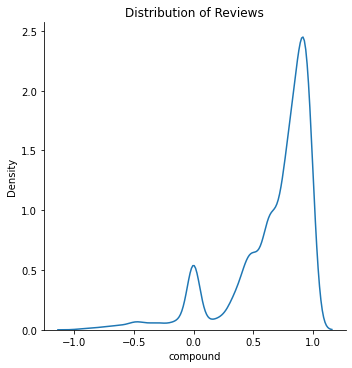

In [42]:
# Generate displot

import seaborn as sns

sns.displot(x='compound', data=polarity_pd, kind="kde").set(title="Distribution of Reviews")

**Observations:** Most of the reviews are positive. The highest peak is close to 1. There is also a smaller peak of neutral reviews and fewer negative reviews. 

[Text(0.5, 1.0, 'Outliers and Overall Review Distribution')]

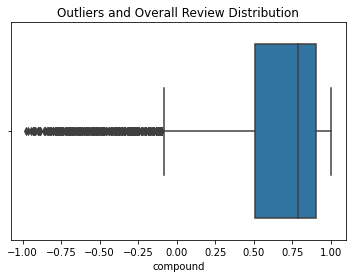

In [43]:
# Examine outliers
sns.boxplot(x="compound", data=polarity_pd).set(title="Outliers and Overall Review Distribution")

**Observations:** There are many negative outliers. The median is close to 0.75, which indicates reviews that are closer to being positive. Removal of the outliers would push the distribution even closer to having more positive reviews.

## Overall thoughts/next steps

The general sentiment of Turtle Games' customers towards its toys and games is positive. A preview of the top 20 positive comments reveals that customers are particularly happy with Turtle Games' products as gifts and that they are perceived as being fun. This could help in the marketing/messaging around its products. 

A preview of the top 20 negative comments reveals that customers are dissatisfied with certain features of the products. 

It would beneficial if Turtle Games has another data set with the product names and/or product categories that can be mapped to the game_reviews file. This would allow Turtle Games to develop a more targeted marketing and product improvement plan to improve sales.